# Probabilistic Decision Making vs. Statistical Significance


This notebook will walk through a concrete set of experiments where you can see the effect of making a decision using null hypothesis significance testing (NHST) via statistical significance or probabilistic decision making via expected utility. At the end we'll see which provides the most value. In addition, you can see what happens over the long run if you make these sorts of decisions. For a nice intro to probabilistic decision making see [this short video](https://www.nytimes.com/video/business/100000004868264/making-choices-like-a-poker-champ.html?partner=slack&smid=sl-share).


Notice that with NHST you're asking something like "is it very likely that these two are different" and with probabilistic decision making you're asking something like "how often will I be wrong if I make this decision."


We'll consider experiments with different ground truths:


1. Treatment and Control are the same<br>
2. Treatment is better than Control<br>
3. Treatment is worse than Control<br>

<div>When there is a difference we assume it's small, since most experiments have small effects. We do this by randomly drawing from a Beta distribution: Beta(1,20) and throwing out 0s.</div>


In [1]:
// How many simulations of experiments do you want to run
val numberOfExperimentsToRun: Int = 10000
// What should the average value of your control or treatment be
val rangeOfMeans: (Double, Double) = (-100, 100)
// Approximately how many of the experiments will have a control that is the same as the treatment
// It's approximate because we use a random number generator to determine if any individual experiment should not be different
// (the remainder will be evenly split be better or worse)
val percentNoDifference: Double = 0.5
// How many units (or users) will be in each sample
val unitsPerTreatment: Int = 10000

In [2]:
case class Experiment(
    controlMean: Double, 
    controlStandardDeviation: Double, 
    treatmentMean: Double, 
    treatmentStandardDeviation: Double,
    truth: String)

// evaluates to (
//    stat sig,
//    expected utility greater than 50%, 
//    does the sample reflect the direction of the population
// )
def runAnExperiment(e: Experiment): (Boolean, Boolean, Boolean) = {

    import org.apache.commons.math3.distribution.NormalDistribution
    import org.apache.commons.math3.stat.inference.TTest
    import org.apache.commons.math3.stat.descriptive.moment.StandardDeviation

    val controlPopulation = new NormalDistribution(e.controlMean, e.controlStandardDeviation)
    val treatmentPopulation = new NormalDistribution(e.treatmentMean, e.treatmentStandardDeviation)

    val controlSample = List.fill(unitsPerTreatment)(controlPopulation.sample())
    val treatmentSample = List.fill(unitsPerTreatment)(treatmentPopulation.sample())
    
    val pValue = (new TTest()).tTest(controlSample.toArray, treatmentSample.toArray)

    val controlSamplingStandardDeviation = (new StandardDeviation().evaluate(controlSample.toArray)) / Math.sqrt(unitsPerTreatment)
    val treatmentSamplingStandardDeviation = (new StandardDeviation().evaluate(treatmentSample.toArray)) / Math.sqrt(unitsPerTreatment)

    val controlSamplingDistribution = new NormalDistribution(controlSample.sum / controlSample.size, controlSamplingStandardDeviation)
    val treatmentSamplingDistribution = new NormalDistribution(treatmentSample.sum / treatmentSample.size, treatmentSamplingStandardDeviation)

    val numberOfSimulations = 10000
    // Monte Carlo simulation for number of times control wins over treatment
    val (controlWins, treatmentWins) = (for (i <- 0 until numberOfSimulations) yield {
        val controlSample = controlSamplingDistribution.sample() 
        val treatmentSample = treatmentSamplingDistribution.sample()
        if (controlSample > treatmentSample) {
            (1,0)
        } else if (controlSample == treatmentSample) {
            // if it's a tie, then flip a coin
            if (scala.util.Random.nextDouble > 0.5) {
                (1,0)
            } else {
                (0,1)
            }
        }
        else {
            (0,1)
        }
    }).foldLeft((0,0))((acc, elem) => {
        (acc._1 + elem._1, acc._2 + elem._2)
    })

    // Convert number of wins to probability of winning
    val oneHundredPercent = 100.0
    val pWinControl = controlWins / oneHundredPercent
    val pWinTreatment = treatmentWins / oneHundredPercent

    // We know the true population mean, was the direction of the samples correct?
    // We want to know this to see if our p-value is in the right direction.
    val sampleAgreesWithTruth = (
        e.controlMean > e.treatmentMean && ((controlSample.sum / controlSample.length) > (treatmentSample.sum / treatmentSample.length)) ||
        e.controlMean < e.treatmentMean && ((controlSample.sum / controlSample.length) < (treatmentSample.sum / treatmentSample.length))
    )

    // (bool, bool, bool)
    (pValue <= 0.05, pWinTreatment > 50, sampleAgreesWithTruth)
}

In [5]:
import org.apache.commons.math3.distribution.BetaDistribution

// the distribution of effect sizes
val beta = new BetaDistribution(1, 20)

val visualizeBeta = List.fill(10000)(beta.sample + 0.001)

visualizeBeta

List(0.09850095974406263, 0.02428015771031984, 0.09700851224581168, 0.0459055172191586, 0.00834574548832032, 0.04006067850067432, 0.09079290375275033, 0.06444041169704623, 0.13928089912524344, 0.02848314395970056, 0.041118345532475266, 0.0154071673856420…

In [7]:
{"type":"plot","value":"Out","plotDefinition":{"value":"Out","title":"Out","forceZero":true,"plot":{"type":"histogram","x":{"field":"value"},"binCount":100}}}

In [3]:
import scala.util.Random

def generateExperiment() = {
    val (lowerMean, upperMean) = rangeOfMeans
    val controlMean = lowerMean + Random.nextDouble * (upperMean - lowerMean)
    // Create a random standard deviation that is between 0.5% of the mean and 50% of the mean
    val controlStandardDeviation = Math.abs(controlMean * 0.005 + Random.nextDouble * (controlMean * 0.5 - controlMean * 0.005))
    val (treatmentMean, treatmentStandardDeviation) = {
        if (Random.nextDouble <= percentNoDifference) {
            (controlMean, controlStandardDeviation)
        } else {
            // pick a random effect size that is very small, because most effects are very small
            val m = controlMean + controlMean * (beta.sample + 0.001)
            val sd = Math.abs(m * 0.005 + Random.nextDouble * (m * 0.5 - m * 0.0005))
            (m, sd)
        }
    }

    val truth = {
        if (controlMean == treatmentMean && controlStandardDeviation == treatmentStandardDeviation) {
            "same"
        } else if (controlMean > treatmentMean) {
            "worse"
        } else {
            "better"
        }
    }

    Experiment(
        controlMean,
        controlStandardDeviation,
        treatmentMean,
        treatmentStandardDeviation,
        truth
    )
}

val experiments = List.fill(numberOfExperimentsToRun)(generateExperiment)

// (stat sig times correct, EU times correct), (both correct, EU only correct, stat sig only correct)
val timesCorrect: List[(Int, Int)] = for (e <- experiments) yield {
    def toInt(b:Boolean) = if (b) 1 else 0
    val (statSig, probabilistic, directionallyRepresentativeSample) = runAnExperiment(e)
    val statSigInTheRightDirection = statSig && directionallyRepresentativeSample
    
    if (e.truth == "same") {
        // This is an interesting case because stat sig will tell you it's statistically signifcant sometimes
        // but even though it says that, you still can't make the wrong decision according to our criterion
        // so we give the stat sig approach a courtesy point here
        (toInt(true), toInt(true))
    } else if (e.truth == "better") {
        (toInt(statSigInTheRightDirection), toInt(probabilistic))
    } else {
        (toInt(statSigInTheRightDirection), toInt(!probabilistic))
    }
}

val (statSigCorrect, probCorrect) = timesCorrect.unzip 
val countTimesCorrect = ( 
    (statSigCorrect.sum, probCorrect.sum), 
    ( 
        timesCorrect.count(x => x._1 == 1 && x._2 == 1), 
        timesCorrect.count(x => x._1 == 0 && x._2 == 1), 
        timesCorrect.count(x => x._1 == 1 && x._2 == 0) 
    ) 
)

countTimesCorrect

((9394,9905),(9394,511,0))


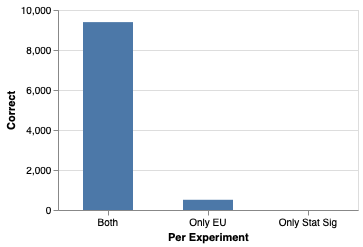

In [4]:
{
  "$schema": "https://vega.github.io/schema/vega-lite/v5.json",
  "description": "How many times each method is correct",
  "width": 300,
  "data": {
    "values": [
      {"Per Experiment": "Both", "Correct": countTimesCorrect._2._1}, 
      {"Per Experiment": "Only EU", "Correct": countTimesCorrect._2._2},
      {"Per Experiment": "Only Stat Sig", "Correct": countTimesCorrect._2._3},
    ]
  },
  "mark": {
    "type": "bar",
    "width": 50,
    "x": 100,
    "strokeWidth": 200
  },
  "encoding": {
    "x": {"field": "Per Experiment", "type": "nominal", "axis": {"labelAngle": 0}},
    "y": {"field": "Correct", "type": "quantitative"}
  }
}